<a href="https://colab.research.google.com/github/Heity94/WalkieLookie/blob/main/JP_Master_Random_RoutingAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install requirements { display-mode: "form" }
!pip install osmnx -q
!pip install geopy -q

     |████████████████████████████████| 95 kB 1.6 MB/s 
     |████████████████████████████████| 1.0 MB 39.1 MB/s 
     |████████████████████████████████| 1.0 MB 42.2 MB/s 
     |████████████████████████████████| 11.2 MB 52.2 MB/s 
     |████████████████████████████████| 62 kB 964 kB/s 
     |████████████████████████████████| 6.3 MB 39.7 MB/s 
     |████████████████████████████████| 16.7 MB 41.2 MB/s 
     |████████████████████████████████| 944 kB 42.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
#@title Imports
import pickle
import folium
import random
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
ox.config(log_console=True, use_cache=True)
from geopy.geocoders import Nominatim
#from networkx.algorithms import approximation as approx # Greedy salesman algorithms
import sklearn
from ast import literal_eval

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Link to common google drive folder (you have to add a link from the foder to your drive first)
data_path = "/content/drive/MyDrive/BPI Lap WalkieLookie/Data/"
#data_path = "/content/drive/MyDrive/WalkieLookie/BPI Lap WalkieLookie/Data" #Roger
#data_path="/home/valentin_werner/Philipps_Playground/WalkieLookie/data/" #Philipp Zeno

# Create own Routing algorithm

### Load data

Our algorithm needs two datasets:


1.   Dataframe of potenital places (nodes) of interest (e.g. all parks in Berlin)
2.   Street data from Berlin (graph data)



In [5]:
#Load DataFrame with nodes of interest (NOI)
places_noi = pd.read_csv(data_path+"parks_bln_complete_clean.csv", index_col=0, converters={'col1': literal_eval})

In [6]:
places_noi.sample(3)

,osmid,name,nodes_on_graph,number_nodes_on_graph,center_node,zip,borough
1433,623130292,NaN,"[3508650999, 3508651000, 3508651002, 350865100...",18,3508651010,13127,Pankow
1943,5404753,Hermann-Wundrich-Platz,"[315206351, 315206352, 315206353, 315206354, 3...",56,315206364,12309,Tempelhof-Schöneberg
945,316969675,NaN,"[243712318, 6515239379, 6515239378, 9603699923...",17,6515239381,12359,Neukölln


In [17]:
#load street data from berlin
with open(data_path+'graph_berlin.obj', 'rb') as fp:
  street_graph = pickle.load(fp)

### Create individual functions

In order to calculate a route which takes into consideration the users starting address, time availability, etc. I divided the problem into multiple small functions

Below you can see some toy (user) input data which the different functions will need as arguments. I guess in the end not all of these inputs should have to be set by the user, but only (time, start address, roundtrip=Yes/No). For the rest we could work with default values. 

In [7]:
# Example User inputs 
user_time = 10 # in minutes
start_address = "Zossener Straße 11, 10961 Berlin" #address as a string
round_trip=True # wheter you want to return to the start 
avg_speed =5 # in km/h
time_margin = 10 # in minutes -> the end route should be within a time range +- 10 minutes from what the user defined 
optimizer = "time" #optimizer for the shortest path algorithm 

For now my routing algorithm is only taking into account one node (the center node) per park. This is of course not ideal yet, but works for now. 

In [ ]:
# Function to calculate center node (if possible), otherwise return "No center found"
#def center_nodes(street_graph, places_nodes_on_map):
#  '''Calculate center node of each place of interest, if no center found return string'''
#  try: 
#    return nx.center(street_graph.subgraph(places_nodes_on_map))[0] #take first center node (in case there are more than 1)
#  except:
#    return "No center found"

In [ ]:
#def get_noi(street_graph, places_noi):
#  '''Based on the graph data and the places of interest dataframe, check which nodes are also in the street data and calculate the center node.
#  Return the dataframe + center nodes as well as a list of nodes to visit (center node per park)
#  '''##
#
#  street_nodes = set(street_graph.nodes())
#
#  # Create column whihc only includes nodes which are also within the berlin graph dats (streets)
#  places_noi["park_nodes_within_graph"] = places_noi.nodes_within_park.apply(lambda x: [node for node in x if node in street_graph])##
#
#  places_noi = places_noi[places_noi.park_nodes_within_graph.apply(lambda x: len(x)) > 0].copy() #Filter out empty parks#
#
#  # Get center node for each park
#  places_noi["center_node"] = places_noi.park_nodes_within_graph.apply(lambda x: center_nodes(street_graph, x))#
#
#  # filter out parks without center (for now)
#  places_noi = places_noi[places_noi.center_node!="No center found"].copy()#
#
#  # Select center park nodes and store as list for route planning
#  nodes_to_visit = places_noi.loc[:,"center_node"].to_list()
#
#  return places_noi, nodes_to_visit

In [78]:
def add_start_end_node(start_address, street_graph, places_df, user_time, avg_speed=5, end_address=None):
  '''Add start (and end address) to list of nodes which should be visited'''

  locator = Nominatim(user_agent = "myapp")

  # stores the start and end points as geopy.point.Point objects
  start_latlng = locator.geocode(start_address).point
  #end_latlng = locator.geocode(end_location).point

  # Find nearest node on the street graph 
  orig_node = ox.distance.nearest_nodes(street_graph, start_latlng[1], start_latlng[0]) #graph, long, lat

  radius = (user_time/60)*avg_speed*350
  subgraph = nx.ego_graph(street_graph, orig_node, radius=radius, distance='length')
  
  places_df_small = places_df.loc[places_df.center_node.isin(subgraph.nodes())]

  nodes_to_visit = [orig_node]+places_df_small.center_node.to_list() #add start node tto list to visit

  return nodes_to_visit, places_df_small, subgraph

In [11]:
def get_route_stats(calc_route, street_graph, avg_speed=5):
  '''Calculate total length and travel time of calculated route'''
    
  # Sum up travel time and distance
  cols = ['osmid', 'length']#, 'travel_time']
  attrs = ox.utils_graph.get_route_edge_attributes(street_graph, calc_route)
  df_route = pd.DataFrame(attrs)[cols]
  
  length_m = df_route.length.sum().round().astype("int")
  travel_time_min = round((df_route.length.sum()/(avg_speed*1000))*60)

  return length_m, travel_time_min

In [103]:
def inital_nodes_to_consider(user_time, nodes_to_visit_final, street_graph, optimizer="time", avg_speed=5):
    '''
    Create first version of nodes the algorithm should consider in the route planning given the users time.
    For the inital route it will consider 1 node of interest for each 5 minutes the user has
    The first point a user visits after the start is the node closest to him/her
    '''

    # given on time: take the starting address and x number of nodes from list 
    x = int(user_time/6) #one place of interest for each 5 minutes
    if x>len(nodes_to_visit_final[1:]): # if number of theoretical nodes to visit is higher than the points of interest in the list take lenght of list
        x = len(nodes_to_visit_final[1:])

    start_node = nodes_to_visit_final[0] #extract start node

    #notes_to_visit_small = np.random.choice(nodes_to_visit_final[1:], x, replace=False).tolist() #sample

    #instead of random sampling of nodes to visit we calculate the distance from the start address and order the list accordingly and then slice it 
    tmp_dict={}

    for node in nodes_to_visit_final[1:]:
        
        shortest_route = nx.shortest_path(street_graph,
                                    start_node,
                                    node,
                                    weight=optimizer)

        #Calculate route statistics for each node
        length_m, travel_time_min = get_route_stats(shortest_route, street_graph, avg_speed)
        
        # Add route and stats to tmp_dict
        tmp_dict[node]={"shortest_path": shortest_route,
                        "length_m": length_m,
                        "travel_time_min": travel_time_min}

    # select shortest path and append to final path list
    df_tmp = pd.DataFrame.from_dict(tmp_dict, orient="index").sort_values(by=["travel_time_min"], ascending=True)
    notes_to_visit_sorted = df_tmp.index.to_list()
    
    notes_to_visit_small = notes_to_visit_sorted[:x]

    return notes_to_visit_small, notes_to_visit_sorted, x, start_node


In [13]:
def create_walking_route(street_graph,  start_node, notes_to_visit_small, round_trip, avg_speed=5):
    ''' 
    Create first version of the walking route based on the list created in inital_nodes_to_consider
    The algorithm will always check the distance between the start and all other nodes and then choose the one closest. 
    From there it will do the same for the remaining nodes until all nodes have been reached
    In case of a round trip it will also incude the way back home to the end of the route
    '''

    final_path = [] #list to store all the final paths
    

     # number of times we heave to run a for loop

    x = notes_to_visit_small.pop(random.randint(0, (len(notes_to_visit_small)-1)))

    shortest_route = nx.shortest_path(street_graph,
                                        start_node,
                                        x,
                                        weight=optimizer)
    

    final_path.append(shortest_route[:-1])

    #length_m, travel_time_min = get_route_stats(shortest_route, street_graph, avg_speed=5)

    #tmp_dict[x]={"shortest_path": shortest_route,
                            #"length_m": length_m,
                            #"travel_time_min": travel_time_min}
    x = shortest_route[-1]

    iterrations = len(notes_to_visit_small)

    for i in range(iterrations):

        # from the starting address calculate shortest path to all other nodes and store distance in list
        tmp_dict={}

        for node in notes_to_visit_small:
            
            
            shortest_route = nx.shortest_path(street_graph,
                                        x,
                                        node,
                                        weight=optimizer)

            #Calculate route statistics for each node
            length_m, travel_time_min = get_route_stats(shortest_route, street_graph, avg_speed=5)
            
            # Add route and stats to tmp_dict
            tmp_dict[node]={"shortest_path": shortest_route,
                            "length_m": length_m,
                            "travel_time_min": travel_time_min}

        # select shortest path and append to final path list
        df_tmp = pd.DataFrame.from_dict(tmp_dict, orient="index")
        node_sh_path_overall = df_tmp.travel_time_min.idxmin()
        shortest_path_overall = df_tmp.loc[node_sh_path_overall, "shortest_path"]
        final_path.append(shortest_path_overall[:-1]) #add all nodes except the last (because the start of next will start at same route)

        x = notes_to_visit_small.pop(notes_to_visit_small.index(node_sh_path_overall)) #remove new start node from list and set as new start point for next iterration
        print(len(notes_to_visit_small))
    #If it is a round trip add one more path from last point to start address to list
    if round_trip==True:

        shortest_route = nx.shortest_path(street_graph,
                                x,
                                start_node,
                                weight=optimizer)

        final_path.append(shortest_route)


    final_path_flat = [x for xs in final_path for x in xs]

    #Calculate route statistics for each node
    length_m, travel_time_min = get_route_stats(final_path_flat, street_graph)

    return final_path_flat, length_m, travel_time_min

In [14]:
def evaluate_iterrate_route(final_path_flat, length_m, travel_time_min, notes_to_visit_sorted, x, start_node, user_time, street_graph, round_trip, time_margin=10, avg_speed=5):
    '''
    This function will take the  inital walking route calculated in "create_walking_route" and check wheter it fits the users timeframe
    If the route is too short or too long it will add/ remove nodes from the list of nodes and rerun the "create_walking_route" function until it fits the timeframe
    '''

    x_init = None

    #Check if travel time is in between +-10 minutes from user time -> if yes return route
    while not ((travel_time_min<=user_time+time_margin) & (travel_time_min>=user_time-time_margin))|(x_init==x):
        
        #save inital x
        x_init = x

        #Check if travel time much smaller than the user time -> if yes add more route points
        if (travel_time_min<(user_time+time_margin)):
            x+= 1 #(user_time-travel_time_min)/5
        elif (travel_time_min>(user_time+time_margin)):
            x-= 1 #(user_time-travel_time_min)/5
        
        #update nodes_to_visist
        notes_to_visit_small = random.sample(notes_to_visit_sorted, x)#[:x]
        final_path_flat, length_m, travel_time_min = create_walking_route(street_graph,start_node,notes_to_visit_small, round_trip=round_trip, avg_speed=5)


    print("Route found")
    return final_path_flat, length_m, travel_time_min, [node for node in final_path_flat if node in notes_to_visit_sorted]

    

## Test functions and plot route

Below you can test the functions and also change the user input as you like ;)

In [116]:
# User inputs 
user_time = 90 # in minutes
start_address = "Arndtstraße 23, 10965 Berlin" #address as a string
round_trip=True # wheter you want to return to the start 
avg_speed =4 # in km/h
time_margin = 10 # in minutes -> the end route should be within a time range +- 10 minutes from what the user defined 
optimizer = "length" #optimizer for the shortest path algorithm 

In [117]:
%%time
# call all functions 
#places_noi, nodes_to_visit = get_noi(street_graph, places_noi)
nodes_to_visit_final, places_df_small, subgraph = add_start_end_node(start_address, street_graph, places_noi, user_time)
notes_to_visit_small, notes_to_visit_sorted, x, start_node = inital_nodes_to_consider(user_time, nodes_to_visit_final, subgraph, optimizer=optimizer, avg_speed=avg_speed)
final_path_flat, length_m, travel_time_min = create_walking_route(subgraph,  start_node, notes_to_visit_small, round_trip, avg_speed)
final_path_flat, length_m, travel_time_min, visited_nodes = evaluate_iterrate_route(final_path_flat, length_m, travel_time_min, notes_to_visit_sorted, x, start_node, user_time, subgraph, round_trip, time_margin, avg_speed)

13
12
11
10
9
8
7
6
5
4
3
2
1
0
12
11
10
9
8
7
6
5
4
3
2
1
0
11
10
9
8
7
6
5
4
3
2
1
0
10
9
8
7
6
5
4
3
2
1
0
9
8
7
6
5
4
3
2
1
0
8
7
6
5
4
3
2
1
0
7
6
5
4
3
2
1
0
6
5
4
3
2
1
0
5
4
3
2
1
0
4
3
2
1
0
3
2
1
0
2
1
0
1
0
0
1
0
2
1
0
1
0
2
1
0
Route found
CPU times: user 56.1 s, sys: 308 ms, total: 56.4 s
Wall time: 57.4 s


In [19]:
travel_time_min

61

In [120]:
# Print result of final route
print("Route length:", length_m)
print("Estimated Travel time:", travel_time_min)
print("Defined Timeframe from user:", user_time)

Route length: 8084
Estimated Travel time: 97
Defined Timeframe from user: 90


In [119]:
#Plot final route
route_plot =ox.plot_route_folium(street_graph, final_path_flat)

# Add marker for start location
start_loc = final_path_flat[0]
latlng_start = (street_graph.nodes()[start_loc]["y"], street_graph.nodes()[start_loc]["x"])
marker = folium.Marker(
            location = latlng_start,
            icon = folium.Icon(color='red', icon="home"))

marker.add_to(route_plot)

#Add markers for nodes along the route
for i, park in enumerate(visited_nodes):
  if i == 0:
    color = 'blue'
  else:
    color = 'green' 
  latlng_parks = (street_graph.nodes()[park]["y"], street_graph.nodes()[park]["x"])
  marker = folium.Marker(
              location = latlng_parks,
              icon = folium.Icon(color=color, prefix='fa', icon="tree"))

  marker.add_to(route_plot)

route_plot #show plot

## My ideas for improving the algorithm

Things which can be further improved:


- Add end address
- When looking for the very first node to visit from the start, instead of using the closest one we could shuffle the first 5 closest ones to make sure that also the route will not always go to the same direction
- Include more nodes of interests from the data Theresa and Eric provided and check if the algorithm is still working (we might have to preprocess your data once and store it in a version so we can work with it) 
- Create different set of "moods" which the user could choose. Each mood would only include certain nodes of interest for the route planning (e.g. mood=explore nature would only consider parks but not tourist attraction) 
- For bigger areas of inetrest (e.g. big park or big tourist attraction) do not only include the "center" node, but also some more nodes. 
- ~~Put algorithm in a python file so it can be easily imported to streamlit~~
- Investigate whether there is some way to prevent the algorithm from walking the same streets multiple times? (dont know if it is possbile to be honest) 
- Add name of parks to the node marker visualization

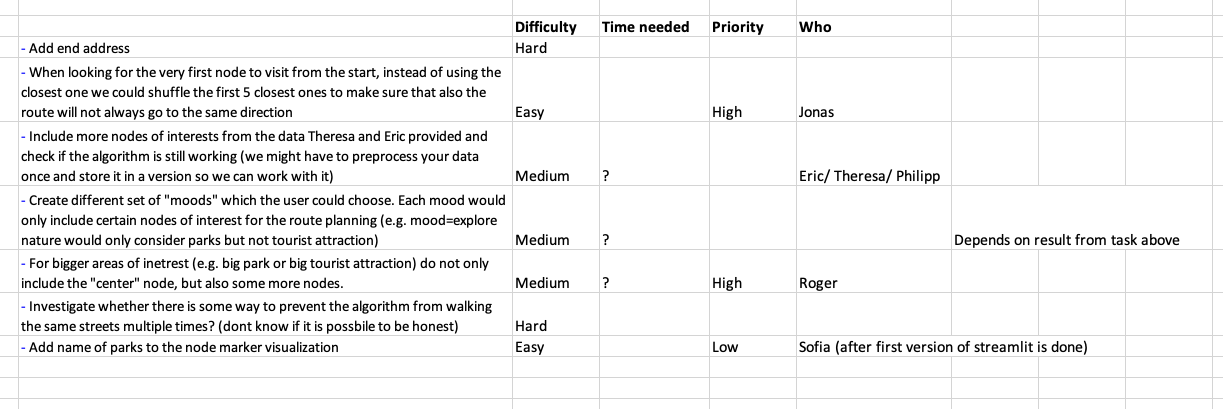